This notebook contains a code which aims at building a multilinear regression model for bitcoin price. The collected variables are as follows:
- WTI oil price [USD] 
- SP500 index value 
- Gold price [USD] 
- Number of bitcoin transactions (on the Coinbase market) 
- Volume of bitcoin on the Coinbase market (number of traded bitcoins on a given day)
- M2 money supply in the USA [USD] 

Time period for the data is between 12.2014 and 04.2020

The main idea behind this project was to check if there are any linear price connections between bitcoin and other mainly market assets. Two other factors like number of bitcoin transactions and bitcoin volume (on the Coinbase market) were taken into account.

The project proceeded in the following steps:
1. Data preparation (choosing the proper time period, rejecting unrelated predictors, graphical examination)
2. Model building (all possible linear options regarding predictors)
3. Validatiton of each model by calculating the root mean squared error value using the cross-validation technique 
4. Evaluation of the residual plots of the best model
5. Conclusion

### Loading the dataset. The dataset is created by the author, more details can be found in the raw_data folder.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import probplot
from sklearn.model_selection import train_test_split, KFold,cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('max_colwidth', 100)

In [2]:
data=pd.read_csv('BTC_regression_data.csv',index_col='Date')
data.index=pd.to_datetime(data.index,format='%Y-%m-%d')

### Values changes in time

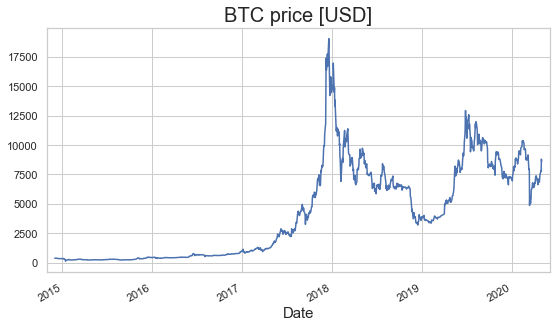

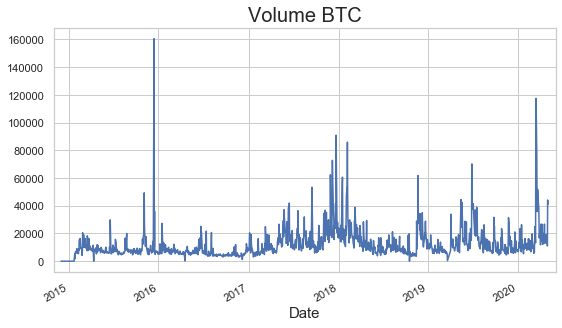

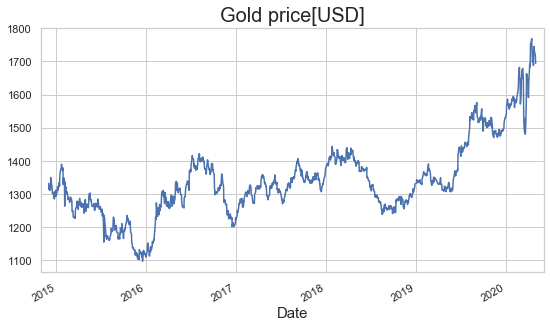

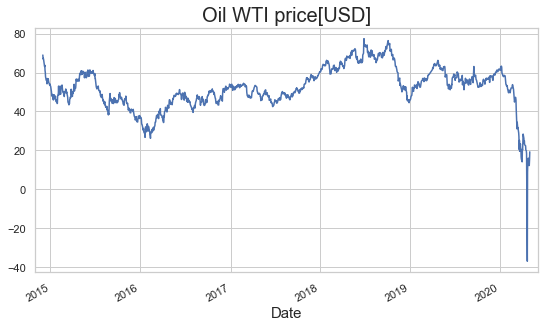

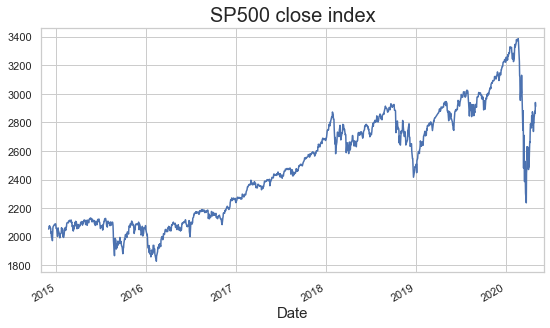

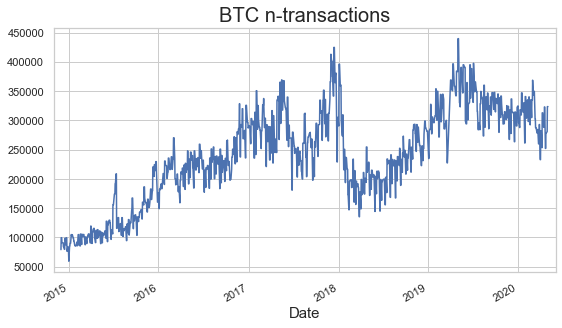

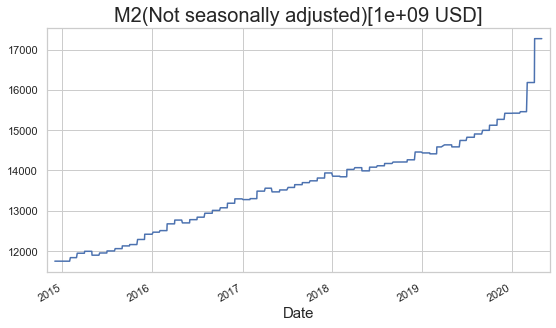

In [3]:
%matplotlib inline

datemin = datetime.date(data.index.min().year, data.index.min().month - 1, 1)
datemax = datetime.date(data.index.max().year, data.index.max().month + 2, 1)
sns.set(style="whitegrid", color_codes=True)

for i in data.columns:

    fig,ax = plt.subplots(figsize=(9,5))      
    data[i].plot(ax=ax)
    plt.gcf().autofmt_xdate()
    ax.set_title(i,fontsize=20)
    ax.set_xlabel('Date',fontsize=15)
    ax.set_xlim([datemin,datemax])
    plt.show()

From the above plots one can infere that bitcoin was not a popular asset until mid-2017. Additionally covid19 pandemic in 2020 caused some unusual action on the market (negative WTI Oil price, huge increase in M2 supply). The last thing worth to mention is that the last bitcoin halving took place in May 2020 - this could be the event that pumped the price.  <br> For the above reasons the time period was limited to 05.2017 - 02.2020 ( _data2_ dataframe)

In [4]:
data2=data.copy()
date_mask = (data2.index > pd.to_datetime('2017-05-01')) & (data2.index < pd.to_datetime('2020-02-01'))
data2 = data2[date_mask]

In [5]:
data2.head()

,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index,BTC n-transactions,M2(Not seasonally adjusted)[1e+09 USD]
Date,,,,,,,
2017-05-02,1471.99,11924.59,1324.0,47.65,2391.17,333161.0,13467.3
2017-05-03,1533.00,16309.77,1315.5,47.79,2388.13,333161.0,13467.3
2017-05-04,1563.39,26688.81,1295.3,45.55,2389.52,333161.0,13467.3
2017-05-05,1551.30,16885.42,1293.7,46.23,2399.29,267193.0,13467.3
2017-05-08,1713.00,15881.13,1294.0,46.46,2399.38,365096.0,13467.3


### Graphical examination of the relationship between bitcoin price and the other features

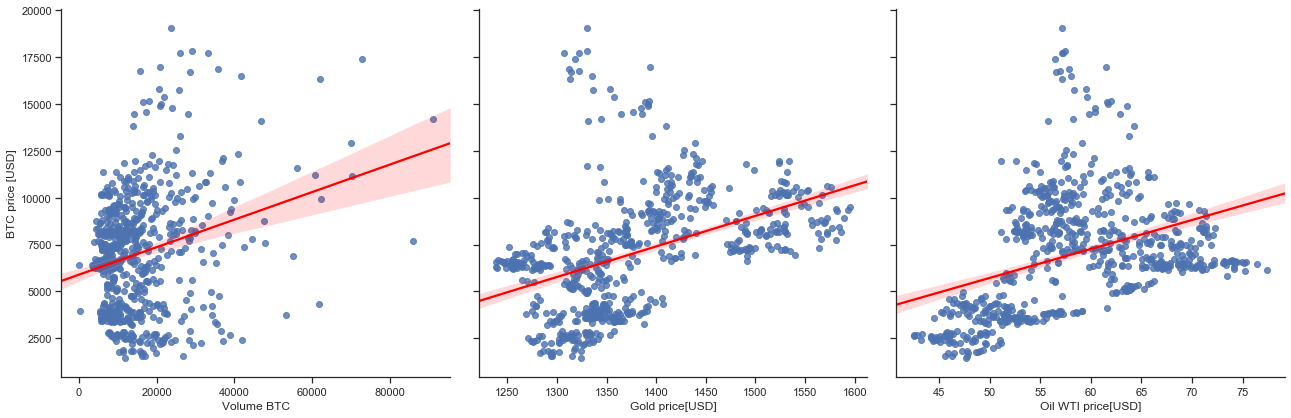

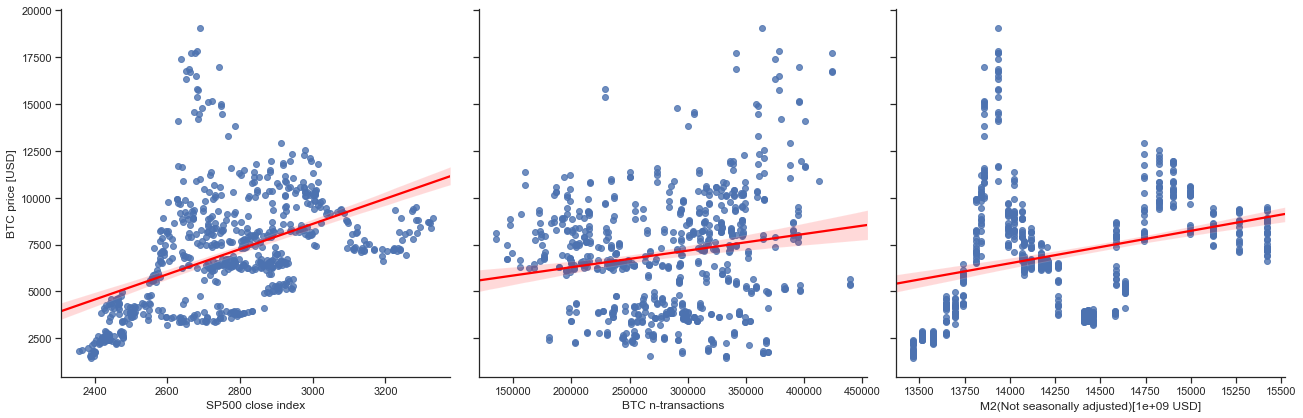

In [6]:
sns.set(style="ticks", color_codes=True)
for i in range(1,len(data2.columns),3):
    g = sns.PairGrid(data2,y_vars='BTC price [USD]',x_vars=data2.columns[i:i+3],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})

The above plots suggest that there hardly is any connection between bitcoin price and number of transactions. This variable is removed. Relationship between bitcoin price and bitcoin volume is questionable, but this variable is kept for the sake of curiosity.

In [7]:
data2.drop(columns=['BTC n-transactions'],inplace=True)

### The author checked if it is possible to obtain more linear relationship using the transformations like $ ln(X), X^2, \sqrt{X} $ but it did not help. The $ \sqrt{X} $ transoformation is shown below

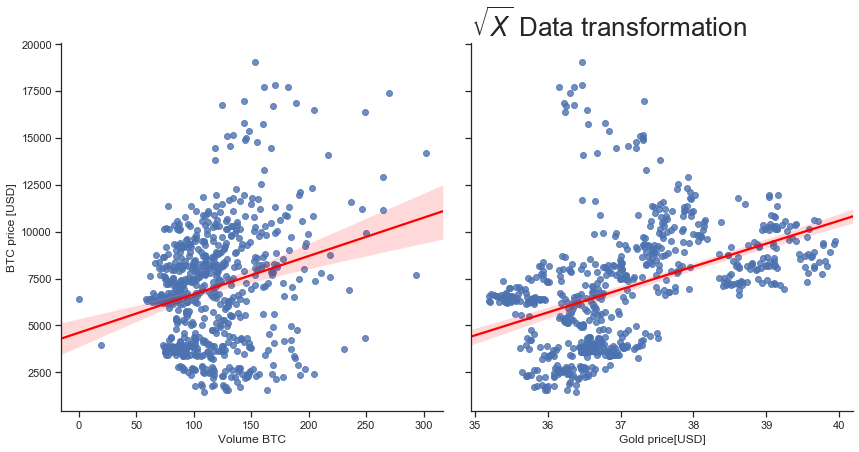

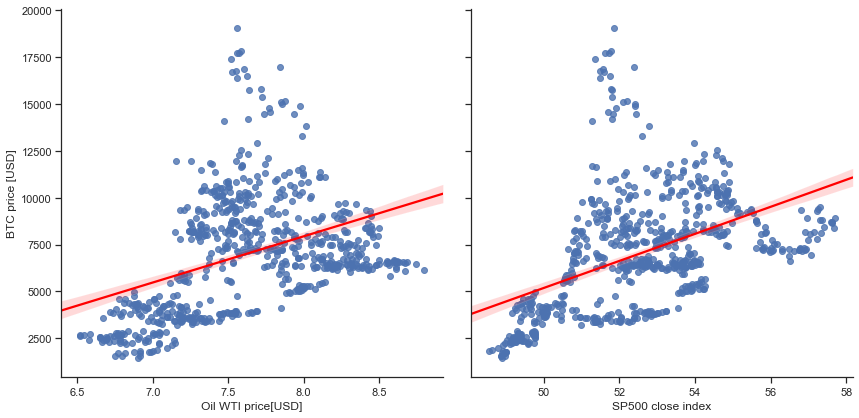

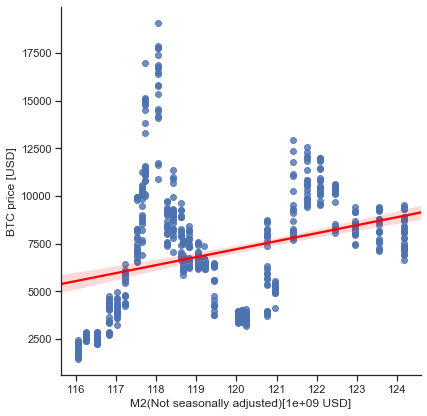

In [8]:
data_sqrt=data2.copy()
data_sqrt.iloc[:,1:]=data_sqrt.iloc[:,1:].apply(lambda x: np.sqrt(x))
s=2
for i in range(1,len(data_sqrt.columns),s):   
    g = sns.PairGrid(data_sqrt,y_vars='BTC price [USD]',x_vars=data_sqrt.columns[i:i+s],height=6)
    g.map(sns.regplot,order=1,line_kws={'color':'red'})
    if i==1:
        plt.title('$\sqrt{X}$ Data transformation ',fontsize=26,loc='left')

### Before proceeding further the correlation matrices and VIF are evaluated in order to exclude multicollinearity

In [9]:
def corr_matrix(dataset,dataname=' '):
    fig,ax = plt.subplots(figsize=(6,6))
    ax= sns.heatmap(dataset.corr(),vmin=0,vmax=1,annot=True)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    ax.set_title('correlation matrix for {}'.format(i))

def vif(dataset):
    X=dataset.drop(columns=['BTC price [USD]'])    
    X=sm.add_constant(X)
    return pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])],index=X.columns).iloc[1:]


VIF for  data2
Volume BTC            1.042345
Gold price[USD]       1.981530
Oil WTI price[USD]    1.561606
SP500 close index     2.381408
dtype: float64


variables with large (>5) VIF:
 Series([], dtype: float64)
 


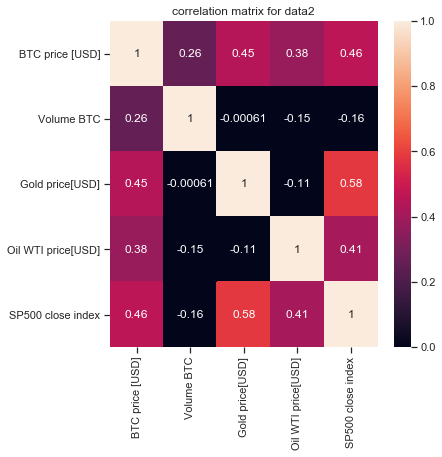

In [27]:
data_list=['data2']
for i in data_list:
    print('\nVIF for ',i)
    ds=vif(eval(i))
    print(ds)
    print("\n")
    print('variables with large (>5) VIF:\n',ds[ds>5] )
    print(" ")
    corr_matrix(eval(i),i)

### Correlation between independent variables

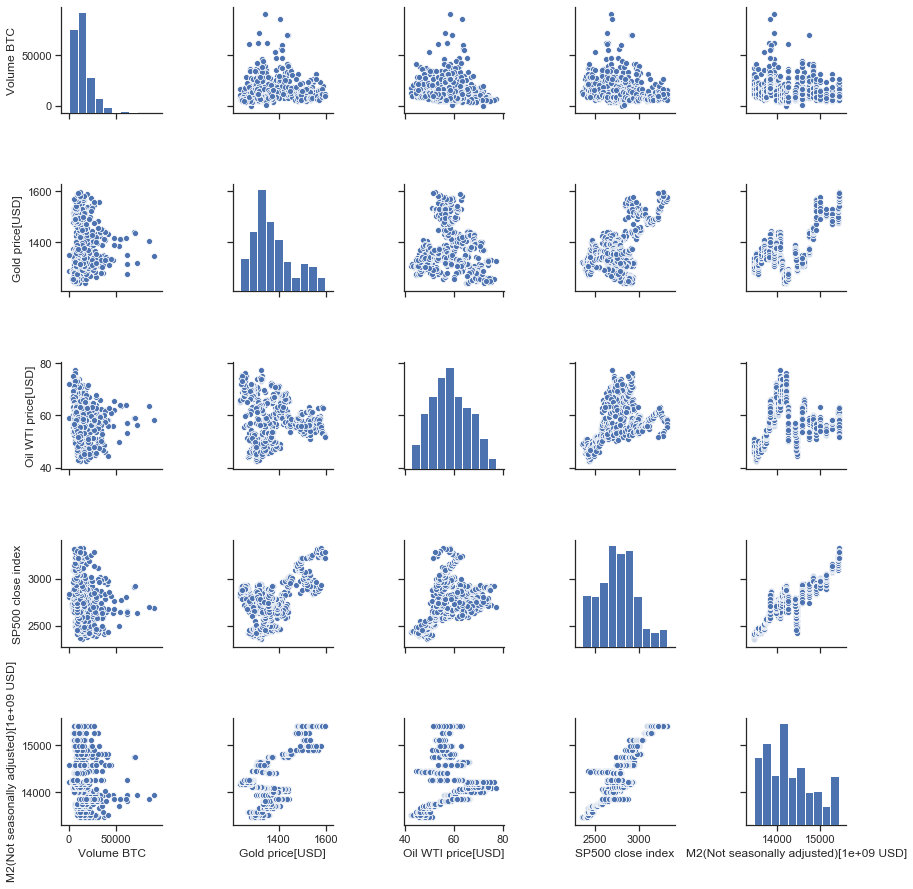

In [11]:
sns.pairplot(data2.drop(columns=['BTC price [USD]']))

M2 and SP500 index are highly correlated. Grahpical examination showed that there is less relationship between bitcoin price and M2 than between bitcoin price and SP500 index. For that reason the money supply M2 variable is removed.

In [12]:
data2.drop(columns=['M2(Not seasonally adjusted)[1e+09 USD]'],inplace=True)

The final dataset is in the following form

In [13]:
data2.head()

,BTC price [USD],Volume BTC,Gold price[USD],Oil WTI price[USD],SP500 close index
Date,,,,,
2017-05-02,1471.99,11924.59,1324.0,47.65,2391.17
2017-05-03,1533.00,16309.77,1315.5,47.79,2388.13
2017-05-04,1563.39,26688.81,1295.3,45.55,2389.52
2017-05-05,1551.30,16885.42,1293.7,46.23,2399.29
2017-05-08,1713.00,15881.13,1294.0,46.46,2399.38


### Multilinear regression
 

In [14]:
y=data2['BTC price [USD]']
X=data2.drop(columns=['BTC price [USD]'])

 Having kept four predictors $ \binom{4}{1} + \binom{4}{2} + \binom{4}{3} + \binom{4}{4} = 15 $ models are possible. __Each__ model is built and validated with 10-fold cross validation technique - the data is split ten times, each time different 90% of the data is used as a train dataset whereas the remaining 10% is used for model validation. Next for every test set (10 times for each model) the root mean squared error is calculated. 

$$ RMSE = \sqrt{\frac{(y_1 - \hat{y_1})^2 + ... + ( y_n - \hat{y_n})^2}{n}} $$

In [28]:
#creating all possible combinations of predictors
from itertools import combinations
comb=[]
for i in range(1,5):
    cols=combinations(data2.columns[1:],i)
    comb.extend(list(cols))

#dataframe for models' parameters    
results_df=pd.DataFrame(columns=['model predictors','MRSE'])   
Rsquared_list=[]
MRSE_all=[]

for i in comb:
    LR=LinearRegression()
    MRSE=cross_val_score(LR,X[list(i)],y,scoring='neg_root_mean_squared_error',cv=10)
    MRSE_all.append(np.array(MRSE))
    model_name=str(i).replace("(","").replace(")","").replace("\'","")
    results_df=results_df.append({'model predictors':model_name,'MRSE':-np.array(MRSE).mean()},ignore_index=True)


idx=results_df['MRSE'].nsmallest(5).index
print('\nthe models with the best parameters are: \n')
results_df.iloc[idx,:]



the models with the best parameters are: 



,model predictors,MRSE
10,"Volume BTC, Gold price[USD], Oil WTI price[USD]",2170.325775
14,"Volume BTC, Gold price[USD], Oil WTI price[USD], SP500 close index",2275.903681
7,"Gold price[USD], Oil WTI price[USD]",2308.534499
13,"Gold price[USD], Oil WTI price[USD], SP500 close index",2465.276993
12,"Volume BTC, Oil WTI price[USD], SP500 close index",2644.396192


### Further examinations of the top 5 models
In order to calculate p-values for the top 5 models the statsmodel library is used

In [17]:
R2_values=[]
for i in np.sort(np.array(idx)):
    X_temp=X[list(comb[i])]
    X_temp=sm.add_constant(X_temp)
    reg=sm.OLS(y,X_temp).fit()
    print(i,'th model with ',comb[i])
    print(reg.summary())
    print('')
    R2_values.append(reg.rsquared)

7 th model with  ('Gold price[USD]', 'Oil WTI price[USD]')
                            OLS Regression Results                            
Dep. Variable:        BTC price [USD]   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.386
Method:                 Least Squares   F-statistic:                     214.0
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           1.02e-72
Time:                        19:18:46   Log-Likelihood:                -6260.4
No. Observations:                 679   AIC:                         1.253e+04
Df Residuals:                     676   BIC:                         1.254e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

C:\Users\Bonias\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


The models 14 is incorrect because of the large p-value for  SP500. The remaining models are

In [18]:
results_df2=results_df.copy()
idx_best=np.array([7,10,12,13,14])
results_df2=results_df2.iloc[idx_best]
results_df2['Rsquared']=R2_values
results_df2[:-1]

,model predictors,MRSE,Rsquared
7,"Gold price[USD], Oil WTI price[USD]",2308.534499,0.387644
10,"Volume BTC, Gold price[USD], Oil WTI price[USD]",2170.325775,0.495622
12,"Volume BTC, Oil WTI price[USD], SP500 close index",2644.396192,0.388558
13,"Gold price[USD], Oil WTI price[USD], SP500 close index",2465.276993,0.387691


The model 10 is the best from the received. The model's parameters are shown below 

In [19]:
X10=data2[list(comb[10])]
X10=sm.add_constant(X10)
reg=sm.OLS(data2.iloc[:,0],X10).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        BTC price [USD]   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     221.1
Date:                Tue, 02 Jun 2020   Prob (F-statistic):          7.01e-100
Time:                        19:18:47   Log-Likelihood:                -6194.6
No. Observations:                 679   AIC:                         1.240e+04
Df Residuals:                     675   BIC:                         1.242e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const              -3.121e+04   1617.125    -19.299      0.000   -3.44e+04    -2.8e+04
Volume BTC             0.0942      0.008     12.021      0.000       0.079       0.110
Gold price[USD]       18.3396      1.007     18.214      0.000      16.363      20.317
Oil WTI price[USD]   197.7493     11.282     17.528      0.000     175.597     219.901
==============================================================================
Omnibus:                      280.488   Durbin-Watson:                   0.224
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1501.145
Skew:                           1.794   Prob(JB):                         0.00
Kurtosis:                       9.339   Cond. No.                     3.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Standard error and error plots for regressions

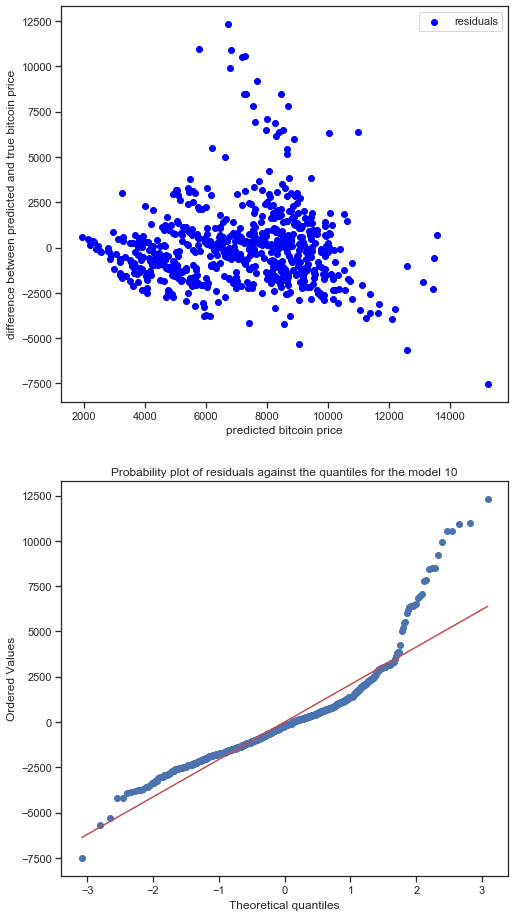

In [20]:
X_error_plot=X[list(comb[10])]
LR.fit(X_error_plot,y)
y_pred=LR.predict(X_error_plot)

fig,ax=plt.subplots(nrows=2,figsize=(8,16))
residuals=y-y_pred

ax[0].scatter(y_pred,residuals,c='blue',label='residuals')
ax[0].set(xlabel='predicted bitcoin price', ylabel='difference between predicted and true bitcoin price')
ax[0].legend()

probplot(residuals, dist='norm', fit=True, plot=ax[1], rvalue=False)
ax[1].set_title('Probability plot of residuals against the quantiles for the model 10')
plt.show()

Predicted price using the best model

In [30]:
price_prediction=pd.DataFrame(columns=['true price','predicted price','difference'])
price_prediction['true price']=y
price_prediction['predicted price']=y_pred
price_prediction['difference']=residuals
price_prediction.sort_index(inplace=True)
price_prediction

,true price,predicted price,difference
Date,,,
2017-05-02,1471.99,3619.492077,-2147.502077
2017-05-03,1533.00,3904.511529,-2371.511529
2017-05-04,1563.39,4069.123511,-2505.733511
2017-05-05,1551.30,3250.463167,-1699.163167
2017-05-08,1713.00,3206.811807,-1493.811807
...,...,...,...
2020-01-27,8895.96,9328.824273,-432.864273
2020-01-28,9394.50,9887.290932,-492.790932
2020-01-29,9288.44,9476.889466,-188.449466


### Summary:
- After rejecting unrelated predictors all possible combinations of remaining predictors were examinated. Each model was tested ten times on the different testset (10 fold cross validation). The model with the lowest MRSE and the highest R-squared value is the model with three predictors: BTC volume, gold price, oil price.
- Excluding few points the residuals have rather linear pattern which whould suggest that model is correct. However probabilty plot of residuals are not placed along the red line. This indicates that the residuals do not have a normal distribution what suggests that the model is incorrect
- the MRSE value is huge. 2170 \$ is a meaningful fraction of bitcoin price (over 10% of the all time high value, whereas over 20% for today's price (01.06.2020))
- The best received model suggest that oil price is the most meaningful for bitcoin price what does not seem sensible.
- The table with true and predicted price shows that the model can be very wrong (difference like 6000\\$) as well as very precise (10$ difference). In general it is not very precise and the best derived model is useless.

### The conclusion

- Bitcoin price is not strongly connected with any of the main market assets. 
- It is impossible to build a linear model which would precisly predict the bitcoin price basing on the main market assets 

